## IMPORTS and PARAMS

In [101]:
%load_ext autoreload
%autoreload 2
import numpy as np
import util
import solver
import engutil
import sympy as sp
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp

## Params from Python driven with 0.15Vrms pink noise
Bl=6.831384111697111
R_e=4.813896577382383
R_m=2.30601776771379
K_m=1714.9942000346673
L_e=0.00033049656807511955
M_m=0.019566105498948536

F = np.array([
    [-R_e/L_e,      0.0,     -Bl/L_e],
    [0.0,         0.0,      1.0  ],
    [Bl/M_m,   -K_m/M_m,   -R_m/M_m ]
])
x0 = np.array([0,0,0])

G = np.array([
    1.0/L_e,
    0.0,
    0.0
])

x0 = np.array([
    0.0,
    0.0,
    0.0
])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Solution with Forward

In [102]:
minimum_fs = util.calculate_min_fs(F)
print(f"Minimum fs: {minimum_fs:.2f}")
fs = int(5*minimum_fs)
# fs = 480000
print(f"fs: {fs}")


duration = 5

pink_noise_20Hz = util.generate_pink_noise(fs*duration, fs, fmin=1)

u = pink_noise_20Hz

x = solver.solve_forward_euler(F, G, u, x0, fs)
X = np.array([x[:,0], x[:,1], x[:,2]])

G_iu_forward, G_du_forward, G_vu_forward, f = util.welchie(u, X, fs)

G_iu_mag_db_forward, G_iu_phase_forward, G_iu_mag_lin_forward  = engutil.tf_to_magphase(G_iu_forward)
G_du_mag_db_forward, G_du_phase_forward, G_du_mag_lin_forward  = engutil.tf_to_magphase(G_du_forward)
G_vu_mag_db_forward, G_vu_phase_forward, G_vu_mag_lin_forward  = engutil.tf_to_magphase(G_vu_forward)

# engutil.plot_bode(f, [(G_iu_mag_db_forward, None)], legends=["Forward"], title="Linear model solved with different solvers $\\hat{G}_{iu}$", xlim=[20, 10e3], ylabel_left="Magnitude $\\left | {G}_{iu} \\right |$ / dB re 1S")

Minimum fs: 7023.90
fs: 35119
len samples: 175595
nperseg = 11706.333333333334
len seconds: 5.0


## Solution with Midpoint

In [103]:
x = solver.midpoint_forward_euler(F, G, u, x0, fs)
X = np.array([x[:,0], x[:,1], x[:,2]])

G_iu_midpoint, G_du_midpoint, G_vu_midpoint, f = util.welchie(u, X, fs)

G_iu_mag_db_midpoint, G_iu_phase_midpoint, G_iu_mag_lin_midpoint  = engutil.tf_to_magphase(G_iu_midpoint)
G_du_mag_db_midpoint, G_du_phase_midpoint, G_du_mag_lin_midpoint  = engutil.tf_to_magphase(G_du_midpoint)
G_vu_mag_db_midpoint, G_vu_phase_midpoint, G_vu_mag_lin_midpoint  = engutil.tf_to_magphase(G_vu_midpoint)

# engutil.plot_bode(f, [(G_iu_mag_db_midpoint, None)], legends=["Midpoint"], title="Linear model solved with different solvers $\\hat{G}_{iu}$", xlim=[20, 10e3], ylabel_left="Magnitude $\\left | {G}_{iu} \\right |$ / dB re 1S")

len samples: 175595
nperseg = 11706.333333333334
len seconds: 5.0


## Solution with RK45

In [113]:
t_eval = np.linspace(0, duration, int(fs*duration))
u = util.generate_pink_noise(fs*duration, fs, fmin=1)
u_func = interp1d(t_eval, u, kind='cubic', fill_value="extrapolate")

params = {
    'Re': R_e, 'Rm': R_m, 'Mm': M_m, 'Bl': Bl, 'Km': K_m, 'Le': L_e
}

sol = solve_ivp(
    fun=solver.loudspeaker_ode_model_A,
    t_span=(0, duration),
    y0=x0,
    t_eval=t_eval,      
    args=(u_func, params), 
    method='RK45',      
    rtol=1e-3,       # 1e-3   (was 5)
    atol=1e-6        # 1e-6 ( was 8)
)

sim_data = np.vstack((sol.t, u, sol.y)).T

X = np.array([sim_data[:,2], sim_data[:,3], sim_data[:,4]])

G_iu_RK45, G_du_RK45, G_vu_RK45, f = util.welchie(u, X, fs)

# engutil.plot_bode(f, [(20*np.log10(np.abs(G_iu_RK45)), None)], legends=["RK45"], title="Linear model solved with different solvers $\\hat{G}_{iu}$", xlim=[20, 10e3], ylabel_left="Magnitude $\\left | {G}_{iu} \\right |$ / dB re 1S")


len samples: 175595
nperseg = 11706.333333333334
len seconds: 5.0


## Excact solution

In [114]:
# f = np.linspace(10,20e3, 16385)
s_val = 2*np.pi*1j*f

G_ui_numeric = R_e + s_val*L_e + (Bl**2 * s_val)/(M_m*s_val**2 + R_m*s_val + K_m)

G_iu_excact = 1/G_ui_numeric

# engutil.plot_bode(f, [(20*np.log10(np.abs(G_iu_excact)), None)], legends=["Excact"], title="Linear model solved with different solvers $\\hat{G}_{iu}$", xlim=[20, 10e3], ylabel_left="Magnitude $\\left | {G}_{iu} \\right |$ / dB re 1S")

## Plot

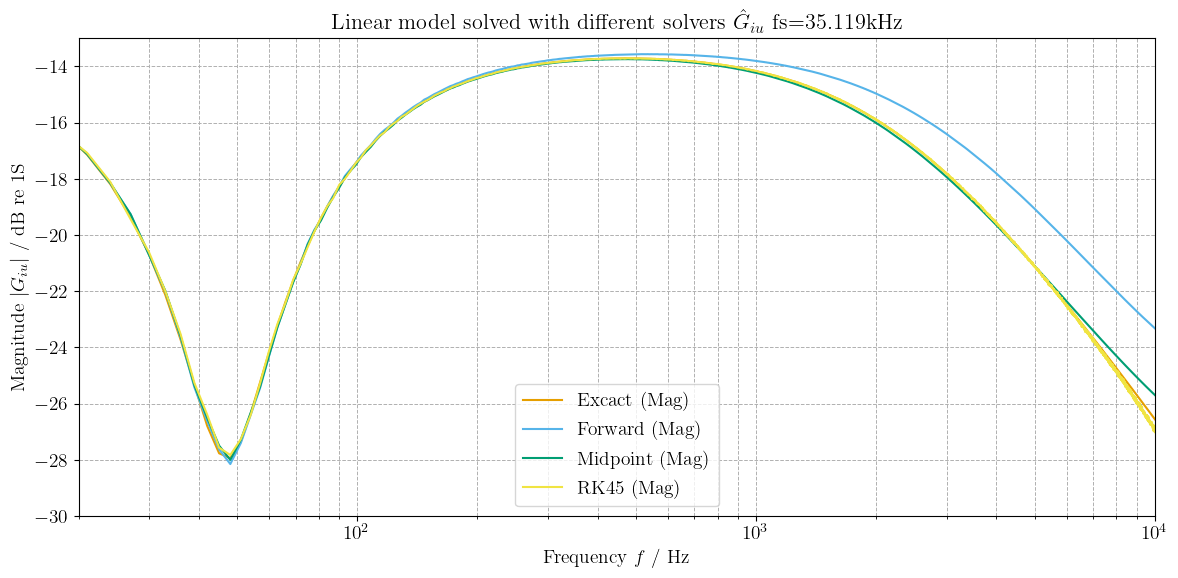

In [116]:
engutil.plot_bode(f, [(20*np.log10(np.abs(G_iu_excact)), None), (G_iu_mag_db_forward, None), (G_iu_mag_db_midpoint, None), (20*np.log10(np.abs(G_iu_RK45)), None)], legends=["Excact", "Forward", "Midpoint", "RK45"], title="Linear model solved with different solvers $\\hat{G}_{iu}$ fs=" + str(fs/1000) + "kHz", xlim=[20, 10e3], ylabel_left="Magnitude $\\left | {G}_{iu} \\right |$ / dB re 1S", ylim_left=[-30,-13], save_loc="figures/comparison_between_different_solvers")

# engutil.plot_bode(f, [(20*np.log10(np.abs(G_iu_excact)), None), (G_iu_mag_db_forward, None), (G_iu_mag_db_midpoint, None), (20*np.log10(np.abs(G_iu_RK45)), None)], legends=["Excact", "Forward", "Midpoint", "RK45"], title="Linear model solved with different solvers $\\hat{G}_{iu}$ fs=" + str(fs/1000) + "kHz", xlim=[20, 10e3], ylabel_left="Magnitude $\\left | {G}_{iu} \\right |$ / dB re 1S", ylim_left=[-30,-13])